# AI Learns the Numbers Third Model

## Initial Setup

In [ ]:
# Import libraries
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import random
import requests
from pathlib import Path
from tqdm.auto import tqdm

In [ ]:
# Creating and downloading the MNIST dataset
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [ ]:
# Write Device Agnostic Code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Dataset Characteristics
This is to explore the MNIST dataset to see what type of data we're going to train our model on.

In [ ]:
# Size of Dataset
len(train_data), len(test_data)

(60000, 10000)

In [ ]:
# Dataset Labels
train_data.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

Text(0.5, 1.0, 'Number 8')

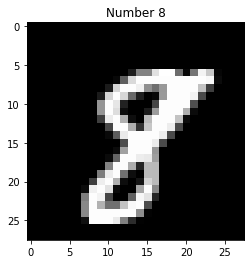

In [ ]:
# Plot One Image
CHANGE_THIS_VARIABLE_TO_SEE_ANOTHER_NUMBER = 55
image, label = train_data[CHANGE_THIS_VARIABLE_TO_SEE_ANOTHER_NUMBER]
plt.imshow(image.squeeze(), cmap="gray")
plt.title("Number "+str(label))

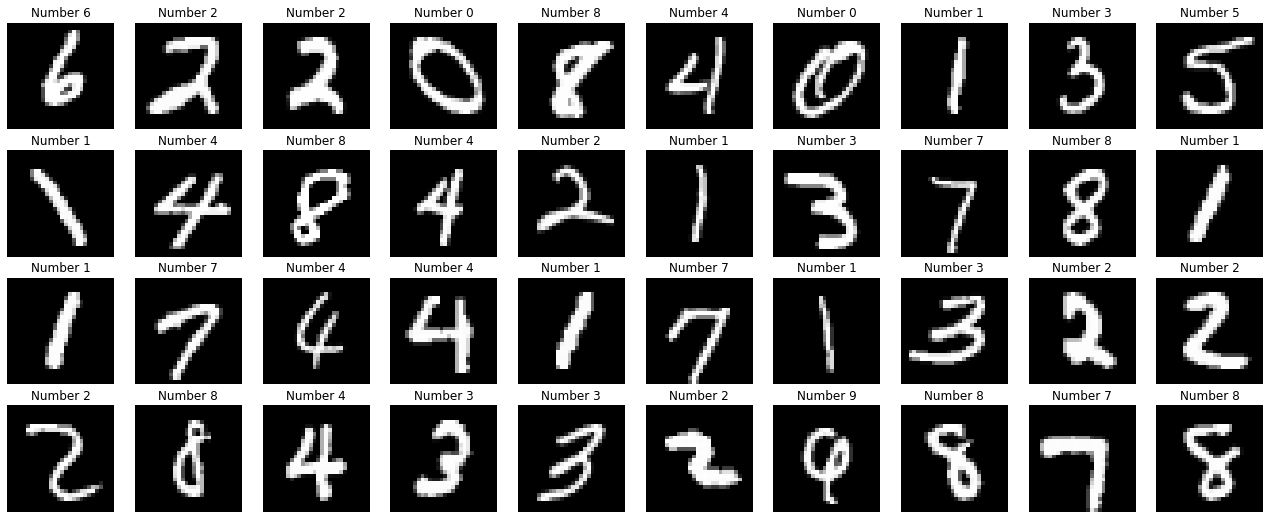

In [ ]:
# Plot 40 Random Images from the Datset - Re-run Code to see new ones
fig = plt.figure(figsize=(22.5, 9))
rows, cols = 4, 10
for i in range(1, rows*cols+1):
  image, label = train_data[random.randint(0,len(train_data))]
  fig.add_subplot(rows, cols, i)
  plt.imshow(image.squeeze(), cmap="gray")
  plt.title("Number "+str(label))
  plt.axis(False)

In [ ]:
# Make PyTorch DataLoader
BATCH_SIZE = 32

# Dataset Used to Train the Model
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True)

# Dataset Used to Test the Model
test_dataloader = DataLoader(dataset=test_data, 
                              batch_size=BATCH_SIZE, 
                              shuffle=False)
print(train_dataloader.dataset)
print("")
print(test_dataloader.dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


## Creating the Model

In [ ]:
# Make Model 3
# The structure can be seen below
class PrettySmartModel(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, 
                  out_channels=hidden_units, 
                  kernel_size=3, # how big is the square that's going over the image?
                  stride=1, # default
                  padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, 
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                      stride=2) # default stride value is same as kernel_size
    )
    self.block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        # Where did this in_features shape come from? 
        # It's because each layer of our network compresses and changes the shape of our inputs data.
        nn.Linear(in_features=hidden_units*7*7, 
                  out_features=output_shape)
    )


  def forward(self, x: torch.Tensor):
    x = self.block_1(x)
    # print(x.shape)
    x = self.block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x


In [ ]:
model = PrettySmartModule(input_shape=1, 
                      hidden_units=10, 
                      output_shape=len(train_data.classes)).to(device)
model

Model3MNIST(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [ ]:
# Getting helper functions from my friend daniel bourke

if Path("helper_functions.py").is_file():
  print("Python script already downloaded")
else:
  print("Downloading helper_functions.py script")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

Python script already downloaded


In [ ]:
from helper_functions import accuracy_fn
from helper_functions import print_train_time
from timeit import default_timer as timer

# Creating and choosing a loss function and an optimizer
# Change the learning rate to make the network learn faster (and generally less accurate) or slower (and generally more accurate)
LEARNING_RATE = 0.05

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), 
                            lr=LEARNING_RATE,)

## Training the Model

In [1]:
# Start Timer
train_time_start_on_cpu = timer()

# Number of Epochs - Change this to train the network for longer
EPOCHS = 8

# Training Loop
for epoch in tqdm(range(EPOCHS)):
  print(f"Epoch: {epoch}")
  train_loss = 0

  # Load the data in batches to avoid memory problems
  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)
    # Set model to train
    model.train()
    # Perform the forward pass
    y_pred = model(X)
    # Calculate the loss (how bad our model is at predicting the right values)
    loss = loss_fn(y_pred, y)
    # Accumulate the loss
    train_loss += loss
    # Set the gradients of the optimizer to zero
    optimizer.zero_grad()
    # Perform backpropagation
    loss.backward()
    # Performs a single optimization step
    optimizer.step()
  # Calculate the loss across all the data
  train_loss /= len(train_dataloader)

  # Test the model on unseen data
  test_loss, test_acc = 0,0
  model.eval()

  with torch.inference_mode():
    for batch, (X_test, y_test) in enumerate(test_dataloader):
      X_test, y_test = X_test.to(device), y_test.to(device)
      # Our model predicts on test data
      test_pred = model(X_test)
      # Calculate loss and accuracy
      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))
    # Calculate loss and accuracy
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f"Train loss: {train_loss:.4f} | Test loss: {test_loss:.4f} | Accuracy: {test_acc:.4f}\n")

# Stop timer
train_time_end_on_cpu = timer()
# Calculate timer difference
total_train_time_model = print_train_time(start=train_time_start_on_cpu, 
                                            end=train_time_end_on_cpu,
                                            device=str(next(model.parameters()).device))

NameError: ignored

## Evaluating the Model

In [ ]:
# Evaluate Model on Unseen Data
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 0 results on test dataset
model_results = eval_model(model=model, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
model_results

{'model_name': 'Model3MNIST',
 'model_loss': 0.04068653658032417,
 'model_acc': 98.56230031948881}

### Making predictions of random images

In [ ]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
  pred_probs = []
  model.eval()
  with torch.inference_mode():
      for sample in data:
          # Prepare sample
          sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

          # Forward pass (model outputs raw logit)
          pred_logit = model(sample)

          # Get prediction probability (logit -> prediction probability)
          pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

          # Get pred_prob off GPU for further calculations
          pred_probs.append(pred_prob.cpu())
          
  # Stack the pred_probs to turn list into a tensor
  return torch.stack(pred_probs)

In [ ]:
def plot_predictions(test_samples, test_labels):
  # Plot predictions
  plt.figure(figsize=(40, 40), facecolor='black')
  nrows = 3
  ncols = 3
  for i, sample in enumerate(test_samples):
    # Create a subplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the target image
    plt.imshow(sample.squeeze(), cmap="gray")

    # Find the prediction label (in text form, e.g. "Sandal")
    pred_label = train_data.classes[pred_classes[i]]

    # Get the truth label (in text form, e.g. "T-shirt")
    truth_label = train_data.classes[test_labels[i]] 

    # Create the title text of the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"
    
    # Check for equality and change title colour accordingly
    if pred_label == truth_label:
        plt.title(title_text, fontsize=25, c="g") # green text if correct
    else:
        plt.title(title_text, fontsize=25, c="r") # red text if wrong
    plt.axis(False);

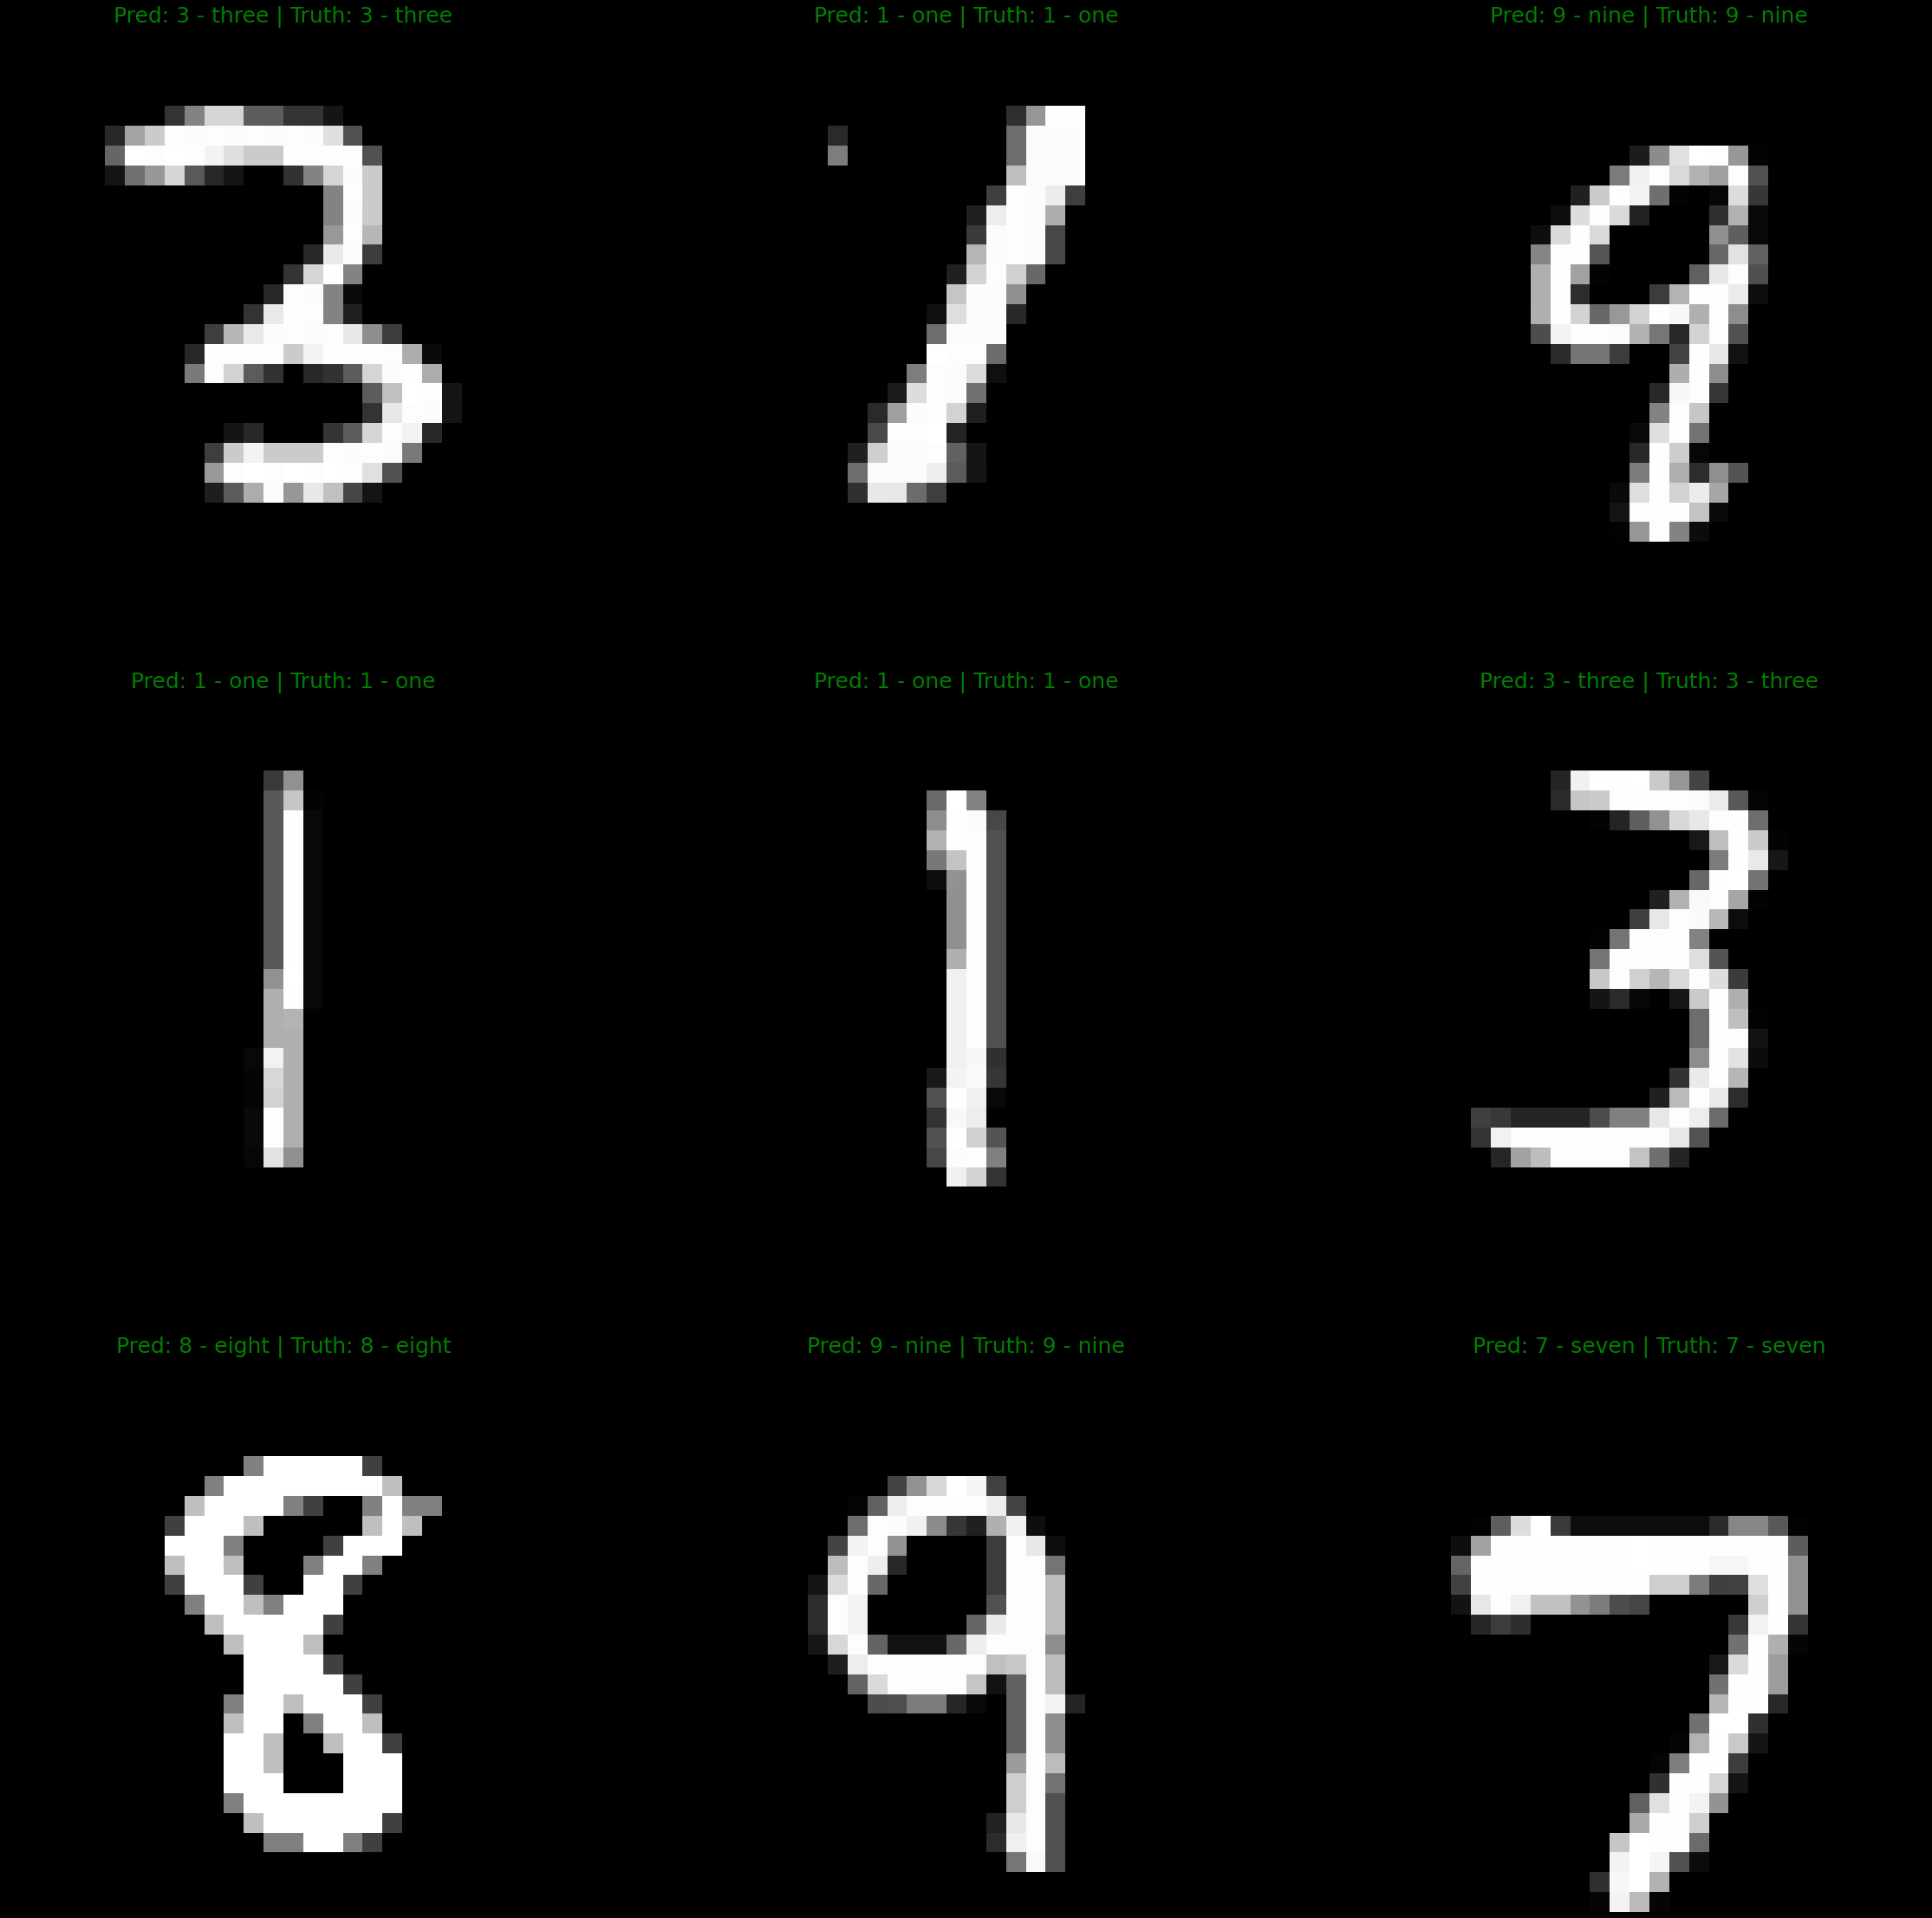

In [ ]:
import random
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

pred_probs= make_predictions(model=model, 
                             data=test_samples)
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)

# Make Predictions
plot_predictions(test_samples, test_labels)

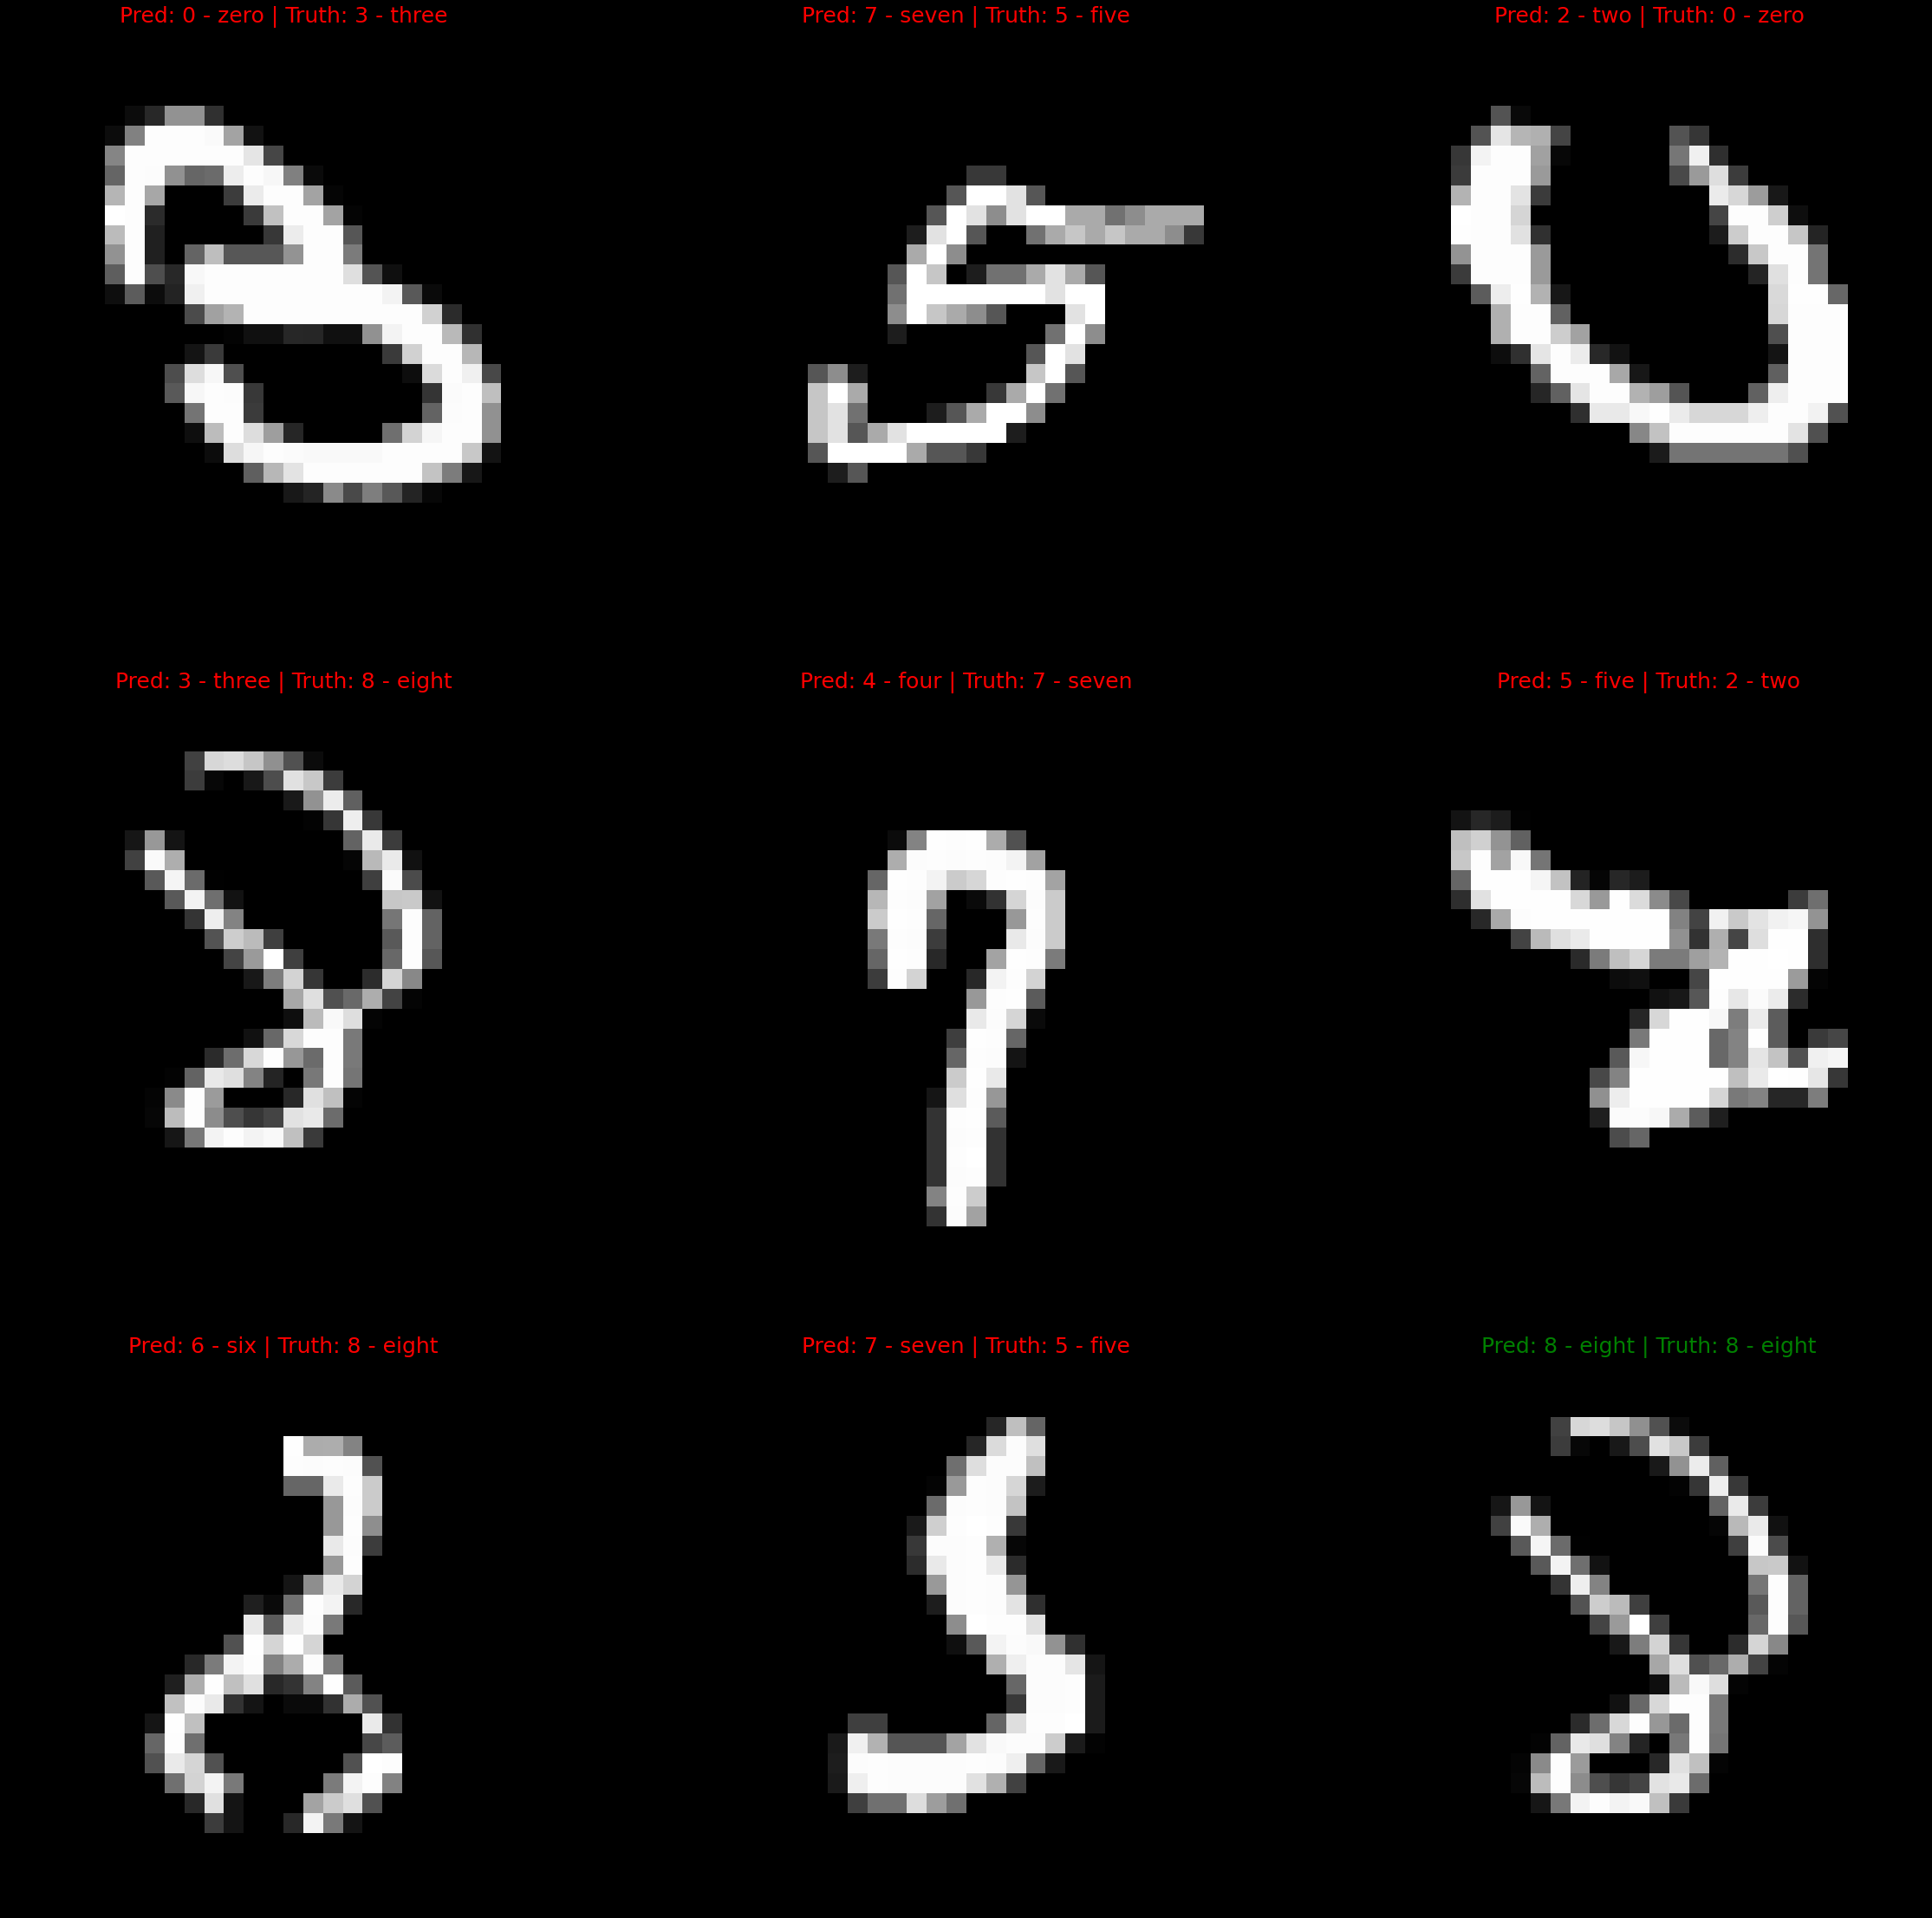

In [ ]:
wrong_samples = []
wrong_labels = []
counter = 9

while counter > 0:
  randomNum = random.randint(0,len(test_data))
  sample, label = test_data[randomNum]
  model.eval()
  with torch.inference_mode():
    # Prepare sample
    sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

    # Forward pass (model outputs raw logit)
    pred_logit = model(sample)

    # Get prediction probability (logit -> prediction probability)
    pred_prob = torch.softmax(pred_logit.squeeze(), dim=0).cpu()
    classNumber = torch.argmax(pred_prob).item()

  if str(classNumber) != str(label):
    wrong_samples.append(sample.cpu())
    wrong_labels.append(label)
    counter -= 1

# Make Predictions
plot_predictions(wrong_samples, wrong_labels)

### Making Confusion Matrix

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [ ]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.21.0


In [ ]:
# Import mlxtend upgraded version
import mlxtend 
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.21.0


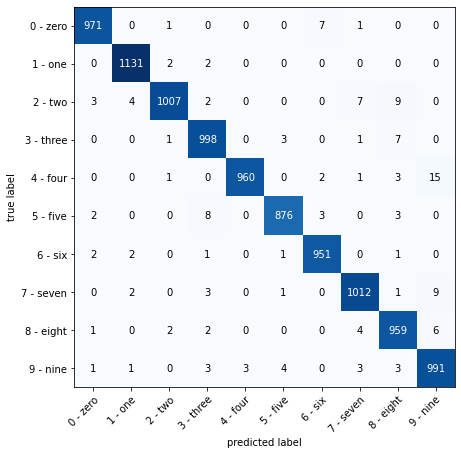

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(train_data.classes), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=train_data.classes, # turn the row and column labels into class names
    figsize=(10, 7)
);

## Let's Try to Predict my Drawn Numbers

### Easy Numbers

In [ ]:
import os
tensorImages, tensorLabels = [], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
directoryImages = os.listdir("./imagesEasy")
directoryImages = sorted(directoryImages)
directoryImages

['Easy Image 0.jpg',
 'Easy Image 1.jpg',
 'Easy Image 2.jpg',
 'Easy Image 3.jpg',
 'Easy Image 4.jpg',
 'Easy Image 5.jpg',
 'Easy Image 6.jpg',
 'Easy Image 7.jpg',
 'Easy Image 8.jpg',
 'Easy Image 9.jpg']

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image

for imagePath in directoryImages:
  img = Image.open('./imagesEasy/'+imagePath)
  transform1 = transforms.Grayscale()
  transform2 = transforms.ToTensor()

  img = transform1(img)
  tensorImage = transform2(img)
  tensorImages.append(tensorImage)

In [ ]:
def plot_predictions_drawn(test_samples, test_labels):
  # Plot predictions
  plt.figure(figsize=(40, 14), facecolor='black')
  nrows = 2
  ncols = 5
  for i, sample in enumerate(test_samples):
    # Create a subplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the target image
    plt.imshow(sample.squeeze(), cmap="gray")

    # Find the prediction label (in text form, e.g. "Sandal")
    pred_label = train_data.classes[pred_classes[i]]

    # Get the truth label (in text form, e.g. "T-shirt")
    truth_label = train_data.classes[test_labels[i]] 

    # Create the title text of the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"
    
    # Check for equality and change title colour accordingly
    if pred_label == truth_label:
        plt.title(title_text, fontsize=25, c="g") # green text if correct
    else:
        plt.title(title_text, fontsize=25, c="r") # red text if wrong
    plt.axis(False);

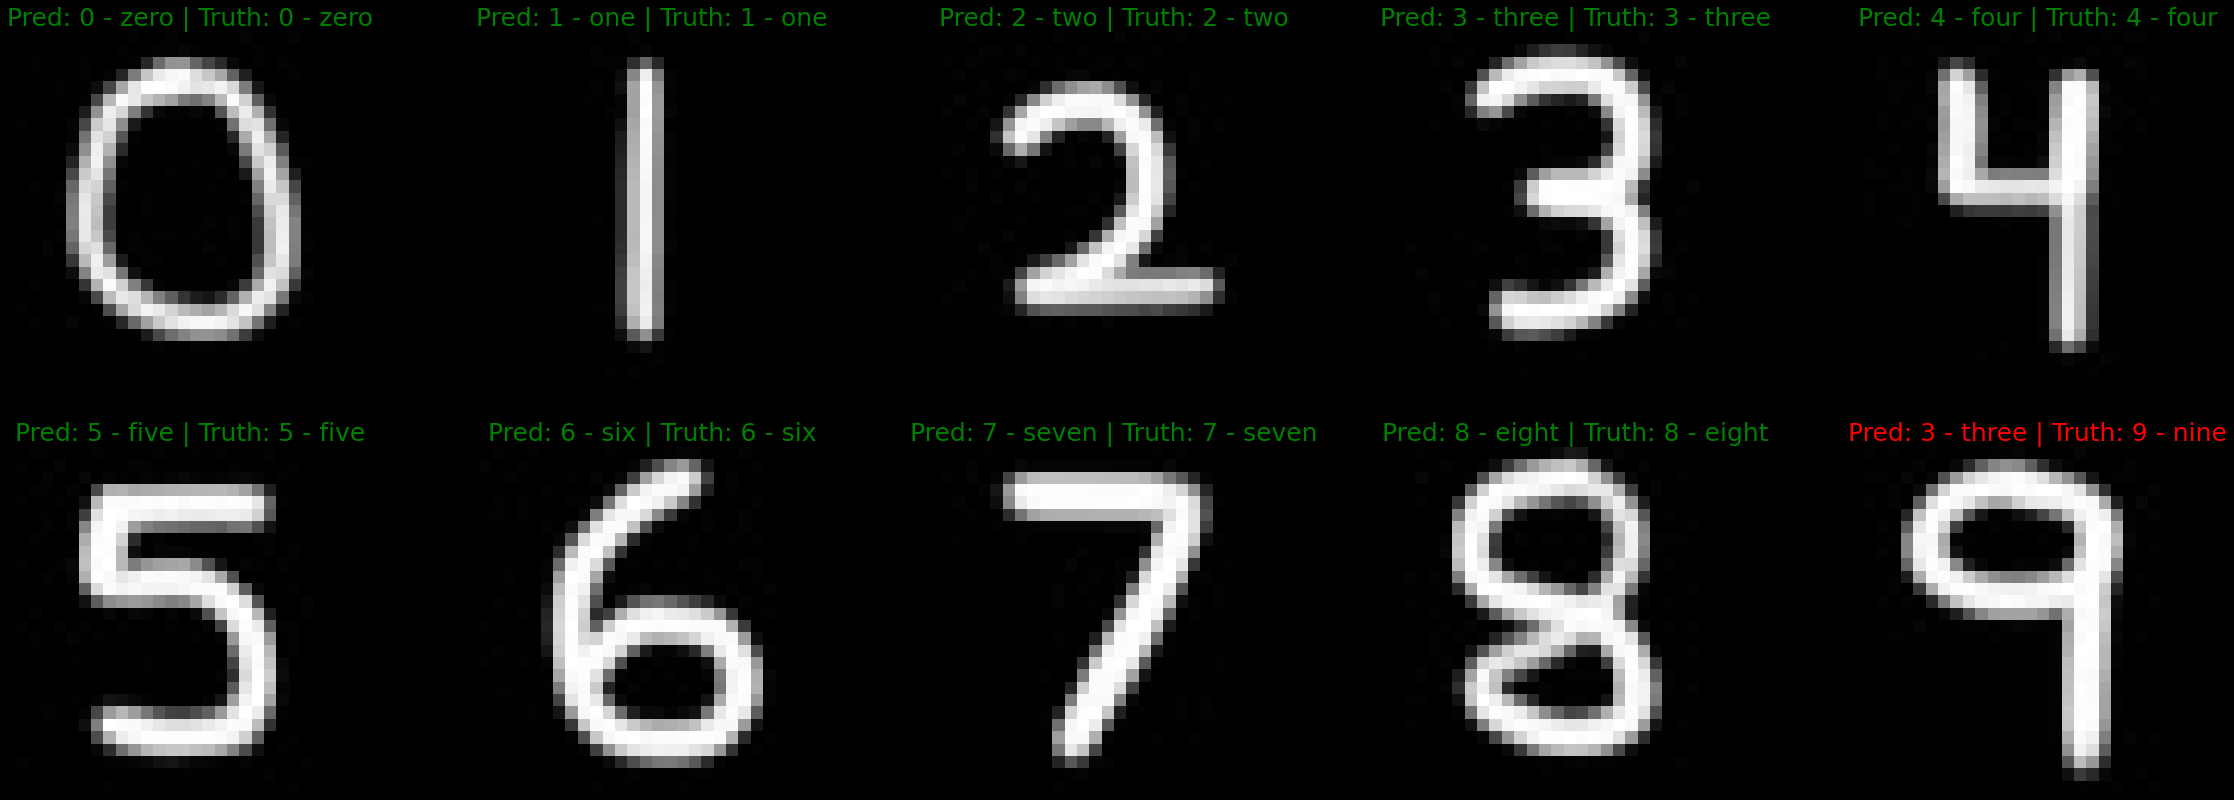

In [ ]:
pred_probs= make_predictions(model=model, 
                             data=tensorImages)
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)

# Make Predictions
plot_predictions_drawn(tensorImages, tensorLabels)

In [ ]:
model.eval()
pred_probs = []
with torch.inference_mode():
  for sample in tensorImages:
    # Prepare sample
    sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

    # Forward pass (model outputs raw logit)
    pred_logit = model(sample)

    # Get prediction probability (logit -> prediction probability)
    pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
    pred_probs.append(pred_prob.cpu())
torch.set_printoptions(precision=2)
torch.set_printoptions(sci_mode=False)
print(pred_probs)

[tensor([    1.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,
            0.00,     0.00,     0.00]), tensor([    0.00,     1.00,     0.00,     0.00,     0.00,     0.00,     0.00,
            0.00,     0.00,     0.00]), tensor([    0.00,     0.00,     1.00,     0.00,     0.00,     0.00,     0.00,
            0.00,     0.00,     0.00]), tensor([    0.00,     0.00,     0.00,     1.00,     0.00,     0.00,     0.00,
            0.00,     0.00,     0.00]), tensor([    0.00,     0.00,     0.00,     0.00,     1.00,     0.00,     0.00,
            0.00,     0.00,     0.00]), tensor([    0.00,     0.00,     0.00,     0.00,     0.00,     1.00,     0.00,
            0.00,     0.00,     0.00]), tensor([    0.00,     0.00,     0.00,     0.00,     0.00,     0.01,     0.99,
            0.00,     0.00,     0.00]), tensor([    0.00,     0.07,     0.00,     0.00,     0.00,     0.00,     0.00,
            0.93,     0.00,     0.00]), tensor([    0.00,     0.00,     0.00,     0.07,     0.0

### Hard Numbers

In [ ]:
tensorImages, tensorLabels = [], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
directoryImages = os.listdir("./imagesHard")
directoryImages = sorted(directoryImages)
directoryImages

['Hard Image 0.jpg',
 'Hard Image 1.jpg',
 'Hard Image 2.jpg',
 'Hard Image 3.jpg',
 'Hard Image 4.jpg',
 'Hard Image 5.jpg',
 'Hard Image 6.jpg',
 'Hard Image 7.jpg',
 'Hard Image 8.jpg',
 'Hard Image 9.jpg']

In [ ]:
for imagePath in directoryImages:
  img = Image.open('./imagesHard/'+imagePath)
  transform1 = transforms.Grayscale()
  transform2 = transforms.ToTensor()

  img = transform1(img)
  tensorImage = transform2(img)
  tensorImages.append(tensorImage)

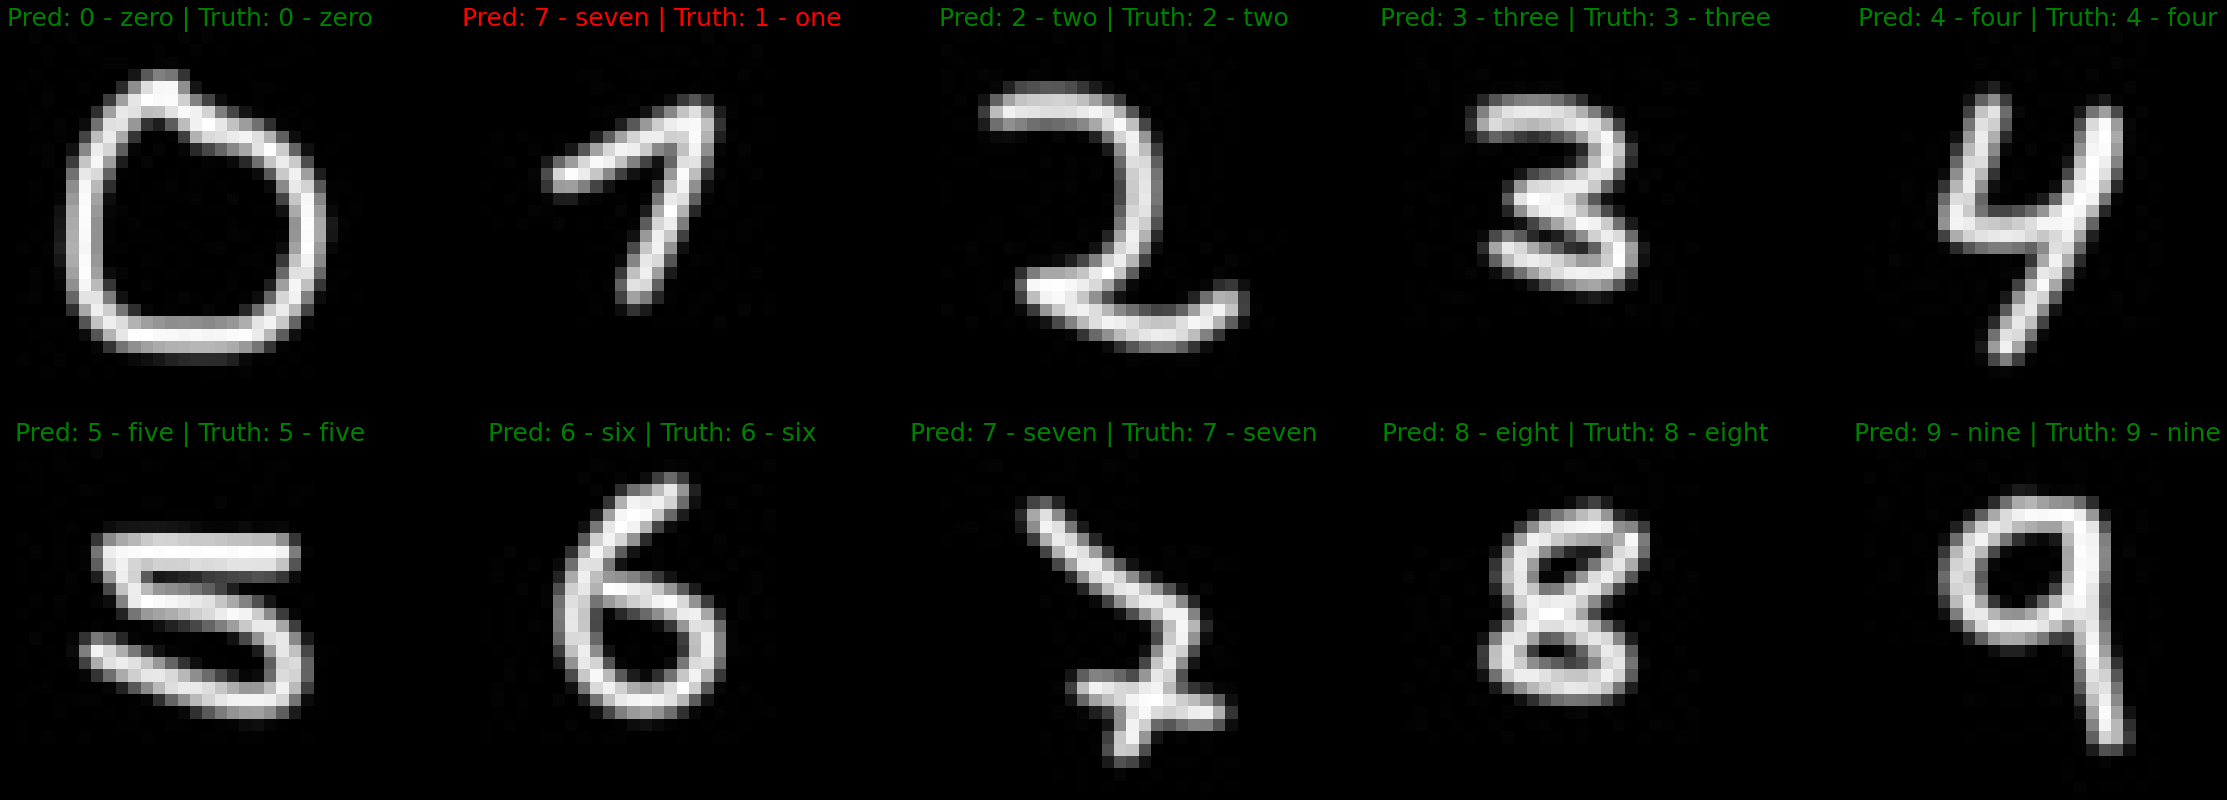

In [ ]:
pred_probs= make_predictions(model=model, 
                             data=tensorImages)
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)

# Make Predictions
plot_predictions_drawn(tensorImages, tensorLabels)

In [ ]:
model.eval()
pred_probs = []
with torch.inference_mode():
  for sample in tensorImages:
    # Prepare sample
    sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

    # Forward pass (model outputs raw logit)
    pred_logit = model(sample)

    # Get prediction probability (logit -> prediction probability)
    pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
    pred_probs.append(pred_prob.cpu())
torch.set_printoptions(precision=2)
torch.set_printoptions(sci_mode=False)
print(pred_probs)

[tensor([    0.97,     0.00,     0.00,     0.00,     0.00,     0.03,     0.00,
            0.00,     0.00,     0.00]), tensor([    0.00,     0.05,     0.14,     0.04,     0.00,     0.00,     0.00,
            0.76,     0.00,     0.00]), tensor([    0.00,     0.04,     0.95,     0.01,     0.00,     0.00,     0.00,
            0.00,     0.00,     0.00]), tensor([    0.00,     0.00,     0.00,     1.00,     0.00,     0.00,     0.00,
            0.00,     0.00,     0.00]), tensor([    0.00,     0.00,     0.00,     0.00,     1.00,     0.00,     0.00,
            0.00,     0.00,     0.00]), tensor([    0.00,     0.00,     0.00,     0.00,     0.00,     1.00,     0.00,
            0.00,     0.00,     0.00]), tensor([    0.00,     0.00,     0.00,     0.00,     0.00,     0.36,     0.63,
            0.00,     0.01,     0.00]), tensor([    0.00,     0.00,     0.15,     0.27,     0.01,     0.17,     0.00,
            0.36,     0.00,     0.04]), tensor([    0.00,     0.00,     0.00,     0.00,     0.0